<a href="https://www.kaggle.com/code/mortezahashemizadeh/smiledetection-2?scriptVersionId=140609879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import requests
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img

# URL to download the dataset
_URL = 'https://inc.ucsd.edu/mplab/398/media/genki4k.tar'
path_to_zip = tf.keras.utils.get_file('genki4k.tar', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip))

# Load labels from text file
labels_file = os.path.join(PATH, 'labels.txt')
with open(labels_file, 'r') as f:
    lines = f.readlines()

image_labels = []  # List to store image labels
for line in lines:
    parts = line.strip().split()
    expression_label = int(parts[0])  # Expression label (smile or non-smile)
    image_labels.append(expression_label)

# Create base directory
base_dir = os.path.join(PATH, 'genki_dataset')
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories for smile and non-smile images
smile_dir = os.path.join(base_dir, 'smile')
non_smile_dir = os.path.join(base_dir, 'non_smile')
os.makedirs(smile_dir, exist_ok=True)
os.makedirs(non_smile_dir, exist_ok=True)

# Organize images based on labels
for idx, label in enumerate(image_labels):
    image_name = f"file{idx+1:04d}.jpg"
    source_path = os.path.join(PATH, 'files', image_name)
    destination_dir = smile_dir if label == 1 else non_smile_dir
    destination_path = os.path.join(destination_dir, image_name)
    os.rename(source_path, destination_path)

# Clean up
os.remove(labels_file)
os.rmdir(os.path.join(PATH, 'files'))
os.remove(path_to_zip)



29255680/29255680 [==============================] - 2s 0us/step


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (255, 255)

train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                                 shuffle=True,
                                                                 validation_split= 0.2,
                                                                 seed = 42,
                                                                 subset = "validation",
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4000 files belonging to 2 classes.

Using 800 files for validation.


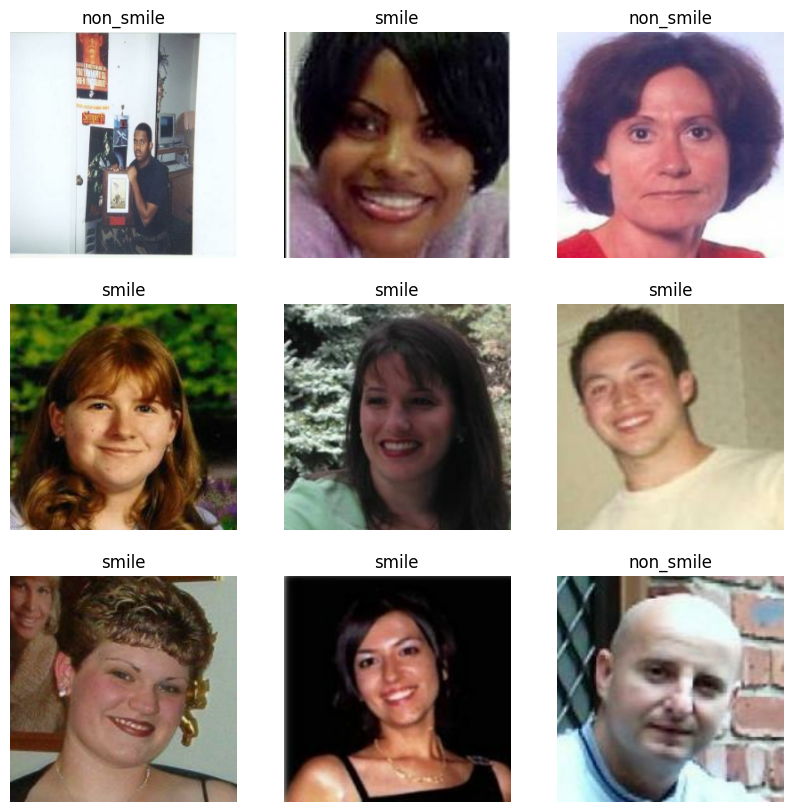

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20

Number of test batches: 5


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

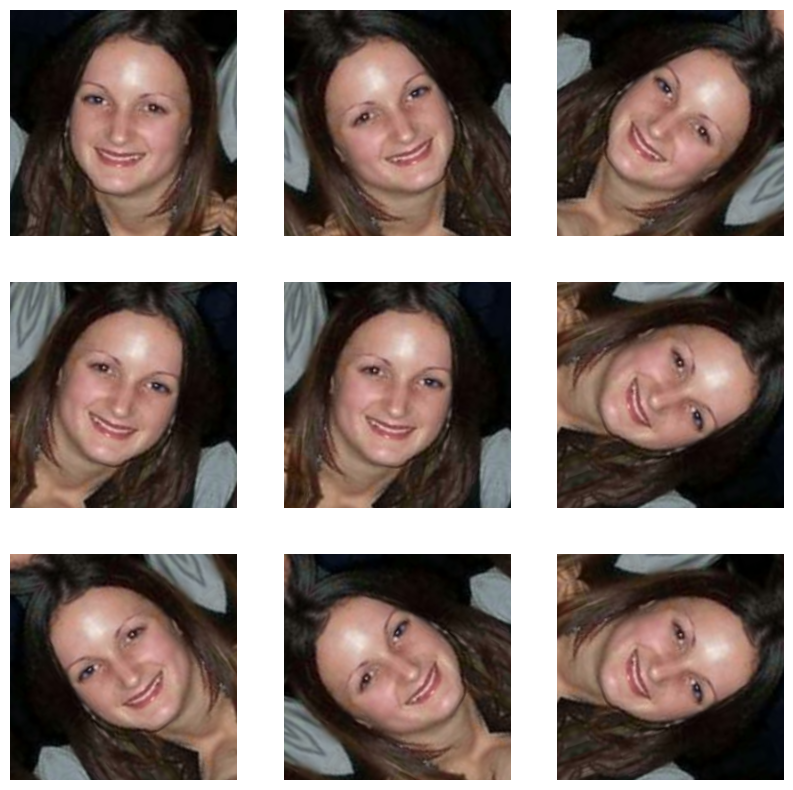

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [25]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255)  # Change here
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


43941136/43941136 [==============================] - 4s 0us/step


In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1536)


In [27]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb3"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_3 (InputLayer)           [(None, 255, 255, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling_4 (Rescaling)        (None, 255, 255, 3)  0           ['input_3[0][0]']                

                                                                                                  

 normalization_1 (Normalization  (None, 255, 255, 3)  7          ['rescaling_4[0][0]']            

 )                                                                                                

                                                                          

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [29]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [30]:
inputs = tf.keras.Input(shape=(255, 255, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_4 (InputLayer)        [(None, 255, 255, 3)]     0         

                                                                 

 sequential (Sequential)     (None, 255, 255, 3)       0         

                                                                 

 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  

                                                                 

 global_average_pooling2d_1   (None, 1536)             0         

 (GlobalAveragePooling2D)                                        

                                                                 

 dropout_1 (Dropout)         (None, 1536)              0         

                                                                 

 dense_1 (Dense)             (None, 1)                 1537      

                                           

In [31]:
len(model.trainable_variables)

2

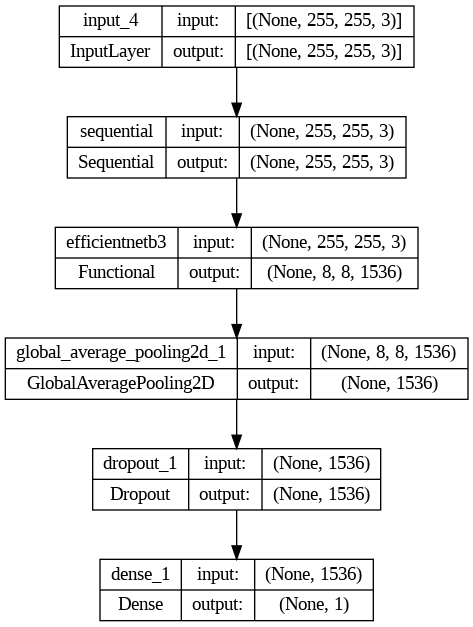

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

20/20 [==============================] - 7s 140ms/step - loss: 0.6911 - accuracy: 0.5328


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69

initial accuracy: 0.53


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10

125/125 [==============================] - 33s 174ms/step - loss: 0.6826 - accuracy: 0.5652 - val_loss: 0.6389 - val_accuracy: 0.6313

Epoch 2/10

125/125 [==============================] - 22s 171ms/step - loss: 0.6459 - accuracy: 0.6260 - val_loss: 0.6160 - val_accuracy: 0.6844

Epoch 3/10

125/125 [==============================] - 22s 172ms/step - loss: 0.6226 - accuracy: 0.6612 - val_loss: 0.5921 - val_accuracy: 0.6922

Epoch 4/10

125/125 [==============================] - 22s 175ms/step - loss: 0.6037 - accuracy: 0.6775 - val_loss: 0.5823 - val_accuracy: 0.6891

Epoch 5/10

125/125 [==============================] - 24s 187ms/step - loss: 0.5943 - accuracy: 0.6873 - val_loss: 0.5736 - val_accuracy: 0.6984

Epoch 6/10

125/125 [==============================] - 22s 173ms/step - loss: 0.5857 - accuracy: 0.6933 - val_loss: 0.5580 - val_accuracy: 0.7031

Epoch 7/10

125/125 [==============================] - 22s 174ms/step - loss: 0.5801 - accuracy: 0.6988 - val_loss: 0.

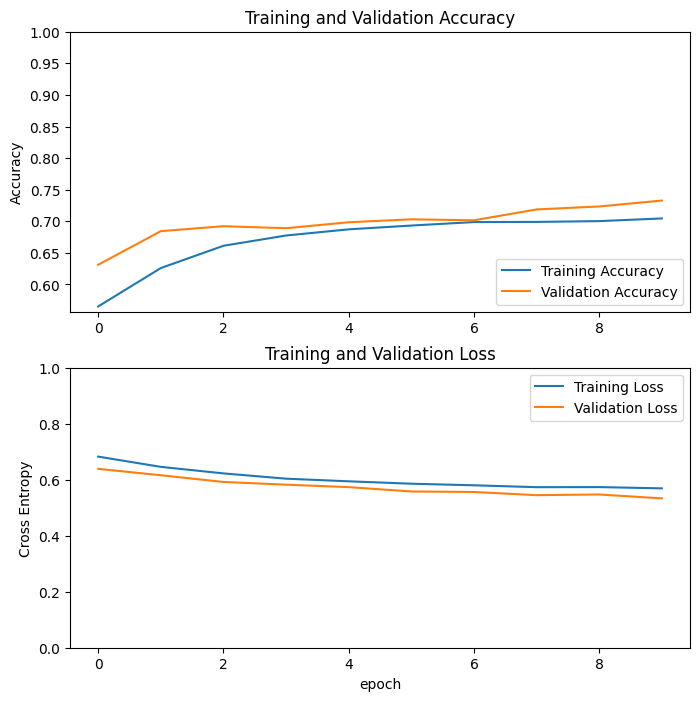

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  385


In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

model.summary()

Model: "model_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_4 (InputLayer)        [(None, 255, 255, 3)]     0         

                                                                 

 sequential (Sequential)     (None, 255, 255, 3)       0         

                                                                 

 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  

                                                                 

 global_average_pooling2d_1   (None, 1536)             0         

 (GlobalAveragePooling2D)                                        

                                                                 

 dropout_1 (Dropout)         (None, 1536)              0         

                                                                 

 dense_1 (Dense)             (None, 1)                 1537      

                                           

In [42]:
len(model.trainable_variables)

298

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20

125/125 [==============================] - 111s 470ms/step - loss: 0.5039 - accuracy: 0.7502 - val_loss: 0.3775 - val_accuracy: 0.8406

Epoch 11/20

125/125 [==============================] - 57s 451ms/step - loss: 0.3596 - accuracy: 0.8430 - val_loss: 0.2584 - val_accuracy: 0.8859

Epoch 12/20

125/125 [==============================] - 57s 456ms/step - loss: 0.2883 - accuracy: 0.8827 - val_loss: 0.2092 - val_accuracy: 0.9094

Epoch 13/20

125/125 [==============================] - 56s 450ms/step - loss: 0.2475 - accuracy: 0.9030 - val_loss: 0.2120 - val_accuracy: 0.9172

Epoch 14/20

125/125 [==============================] - 59s 468ms/step - loss: 0.2252 - accuracy: 0.9172 - val_loss: 0.1907 - val_accuracy: 0.9234

Epoch 15/20

125/125 [==============================] - 57s 453ms/step - loss: 0.2043 - accuracy: 0.9240 - val_loss: 0.1796 - val_accuracy: 0.9156

Epoch 16/20

125/125 [==============================] - 59s 467ms/step - loss: 0.1927 - accuracy: 0.9258 - val_

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

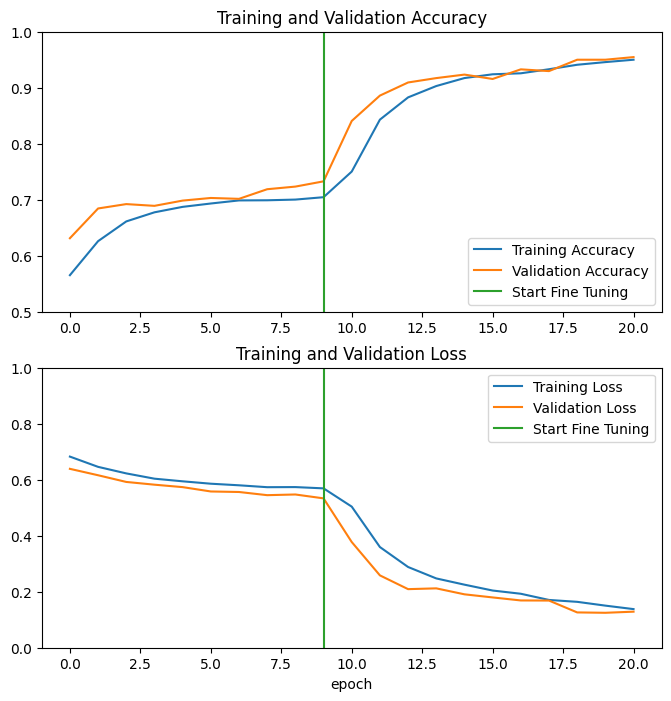

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 141ms/step - loss: 0.1257 - accuracy: 0.9563

Test accuracy : 0.956250011920929


Predictions:

 [0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0]

Labels:

 [0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0]


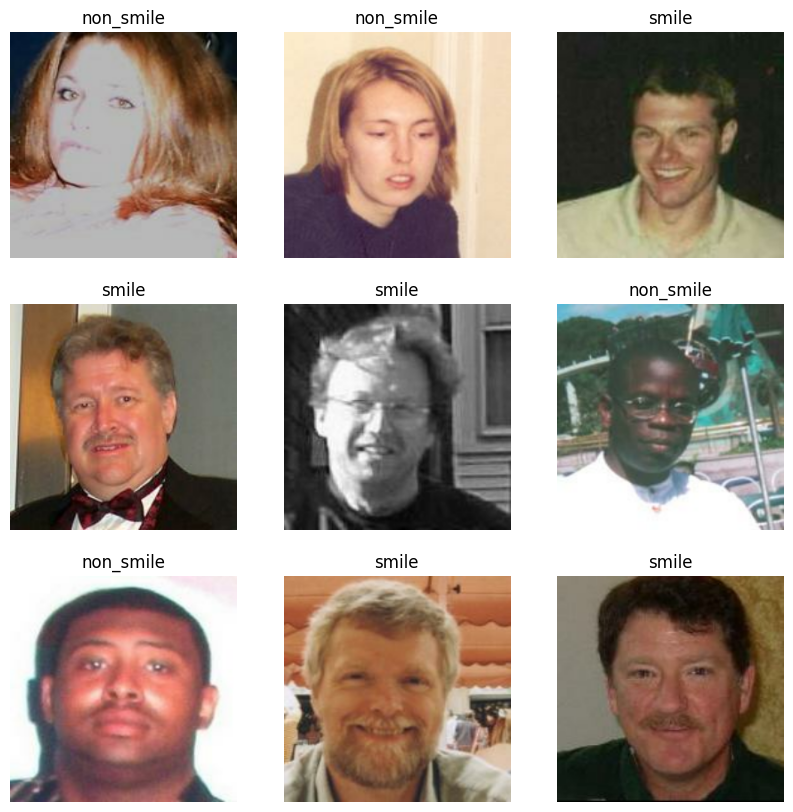

In [47]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")